In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib
import seaborn as sns
%matplotlib inline
import scipy
import sklearn

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.serif'] = ['Arial']
sc.settings.set_figure_params(dpi=150,dpi_save=300,facecolor='white',fontsize=10,vector_friendly=True,figsize=(3,3))
sc.settings.verbosity = 3
import sys
sys.path.append("/home/qukun/xuhao/workspace/Utils")
import sc_plot
from sc_process import grouped_obs_mean
from sc_plot import plot_proportion

In [3]:
cx_epi = sc.read_h5ad('../scripts/CX_20211030/s04_cx_epi.h5ad')

In [10]:
cx_epi

AnnData object with n_obs × n_vars = 27742 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'ident', 'scDblFinder.sample', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'sample', 'RNA_snn_res.2', 'seurat_clusters', 'celltype_submarkers', 'celltype_major', 'celltype_minor', 'cli_state', 'umap_1', 'umap_2'
    var: 'features'
    uns: 'celltype_major_colors', 'celltype_minor_colors', 'neighbors'
    obsm: 'X_PCA', 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    layers: 'scaled'
    obsp: 'distances'

In [9]:
cx_epi.obs[['umap_1','umap_2']] = cx_epi.obsm['X_umap']

In [33]:
cx_epi.obs[['celltype_major','cli_state','umap_1','umap_2']].to_csv('source_data/source_data_fig2a.csv')

In [14]:
cx_epi.to_df().loc[:,['PIP','CRISP3','LRRC26','ODAM','TCN1','BPIFB2','TFF3','AGR2','MUC5B','GOLM1','ADIRF','ANXA1','DEFB1','S100A2','PDLIM1','TPM2','TAGLN','ACTA2','CALD1','KRT14']].to_csv('source_data/source_data_fig2b.csv')

In [4]:
cx_epi_cli_state_df = []
for c in cx_epi.obs.celltype_major.unique():
    cx_epi_ctmp = cx_epi[cx_epi.obs.celltype_major==c].copy()
    sc.tl.rank_genes_groups(cx_epi_ctmp,groupby='cli_state',key_added=f'{c}_cli',method='wilcoxon',pts=True,use_raw=False)
    cx_epi_ctmp_df = sc.get.rank_genes_groups_df(cx_epi_ctmp,group='SjS',key=f'{c}_cli')
    cx_epi_ctmp_df['celltype_major'] = c
    cx_epi_cli_state_df.append(cx_epi_ctmp_df)
cx_epi_cli_state_df = pd.concat(cx_epi_cli_state_df,axis=0)

ranking genes
    finished: added to `.uns['Serous_acini_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:00)
ranking genes
    finished: added to `.uns['Mucous_acini_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)
ranking genes
    finished: added to `.uns['Ductal_cli']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by

In [5]:
cx_epi_cli_state_degs_nofilter = cx_epi_cli_state_df.copy()

In [45]:
cx_epi_cli_state_degs_filter = cx_epi_cli_state_degs_nofilter[(cx_epi_cli_state_degs_nofilter.pvals_adj < 0.01)&(cx_epi_cli_state_degs_nofilter.logfoldchanges > 0.5)]

In [47]:
cx_epi_cli_state_degs_filter.to_csv('source_data/source_data_sfig2a&b.csv')

In [15]:
cx_epi_cli_state_logfc = pd.DataFrame(index=cx_epi_cli_state_df.celltype_major.unique(),columns=cx_epi_cli_state_df.names.unique())
cx_epi_cli_state_pval = pd.DataFrame(index=cx_epi_cli_state_df.celltype_major.unique(),columns=cx_epi_cli_state_df.names.unique())
cx_epi_cli_state_pts = pd.DataFrame(index=cx_epi_cli_state_df.celltype_major.unique(),columns=cx_epi_cli_state_df.names.unique())
cx_epi_cli_state_scores = pd.DataFrame(index=cx_epi_cli_state_df.celltype_major.unique(),columns=cx_epi_cli_state_df.names.unique())
for c in cx_epi_cli_state_df.celltype_major.unique():
    cx_epi_cli_state_df_tmp = cx_epi_cli_state_df[cx_epi_cli_state_df.celltype_major == c]
    cx_epi_cli_state_logfc.loc[c,cx_epi_cli_state_df_tmp.names] = cx_epi_cli_state_df_tmp.logfoldchanges.values
    cx_epi_cli_state_pval.loc[c,cx_epi_cli_state_df_tmp.names] = cx_epi_cli_state_df_tmp.pvals_adj.values
    cx_epi_cli_state_pts.loc[c,cx_epi_cli_state_df_tmp.names] = cx_epi_cli_state_df_tmp.pct_nz_group.values
    cx_epi_cli_state_scores.loc[c,cx_epi_cli_state_df_tmp.names] = cx_epi_cli_state_df_tmp.scores.values
cx_epi_cli_state_logfc = cx_epi_cli_state_logfc.fillna(0)
cx_epi_cli_state_pval = cx_epi_cli_state_pval.fillna(0)
cx_epi_cli_state_pts = cx_epi_cli_state_pts.fillna(0)
cx_epi_cli_state_scores = cx_epi_cli_state_scores.fillna(0)

In [16]:
pval_cutoff=0.01
logfc_cutoff=0.5
cx_epi_cli_state_up_logfc = cx_epi_cli_state_logfc.loc[:,(((cx_epi_cli_state_pts.values > 0.1)&(cx_epi_cli_state_logfc.values > logfc_cutoff)&(cx_epi_cli_state_pval.values < 0.01)).sum(0) != 0)]
cx_epi_cli_state_down_logfc = cx_epi_cli_state_logfc.loc[:,(((cx_epi_cli_state_pts.values > 0.1)&(cx_epi_cli_state_logfc.values < -logfc_cutoff)&(cx_epi_cli_state_pval.values < 0.01)).sum(0) != 0)]
cx_epi_cli_state_all_logfc = cx_epi_cli_state_logfc.loc[:,(((cx_epi_cli_state_pts.values > 0.1)&((cx_epi_cli_state_logfc.values < -logfc_cutoff)|(cx_epi_cli_state_logfc.values > logfc_cutoff))&(cx_epi_cli_state_pval.values < 0.01)).sum(0) != 0)]

In [17]:
cx_epi_cli_state_all_pval = cx_epi_cli_state_pval.loc[:,(((cx_epi_cli_state_pts.values > 0.1)&((cx_epi_cli_state_logfc.values < -logfc_cutoff)|(cx_epi_cli_state_logfc.values > logfc_cutoff))&(cx_epi_cli_state_pval.values < 0.01)).sum(0) != 0)]

In [18]:
cx_epi_cli_state_all_logfc = cx_epi_cli_state_all_logfc.loc[:,cx_epi_cli_state_all_logfc.sum(0)!=0]
cx_epi_cli_state_all_pval = cx_epi_cli_state_all_pval.loc[:,cx_epi_cli_state_all_logfc.sum(0)!=0]

In [19]:
cx_epi_cli_state_logfc_km = np.clip(cx_epi_cli_state_all_logfc,-3,3)

In [21]:
cx_epi_cli_state_logfc_km.to_csv('source_data/source_data_fig2c.csv')

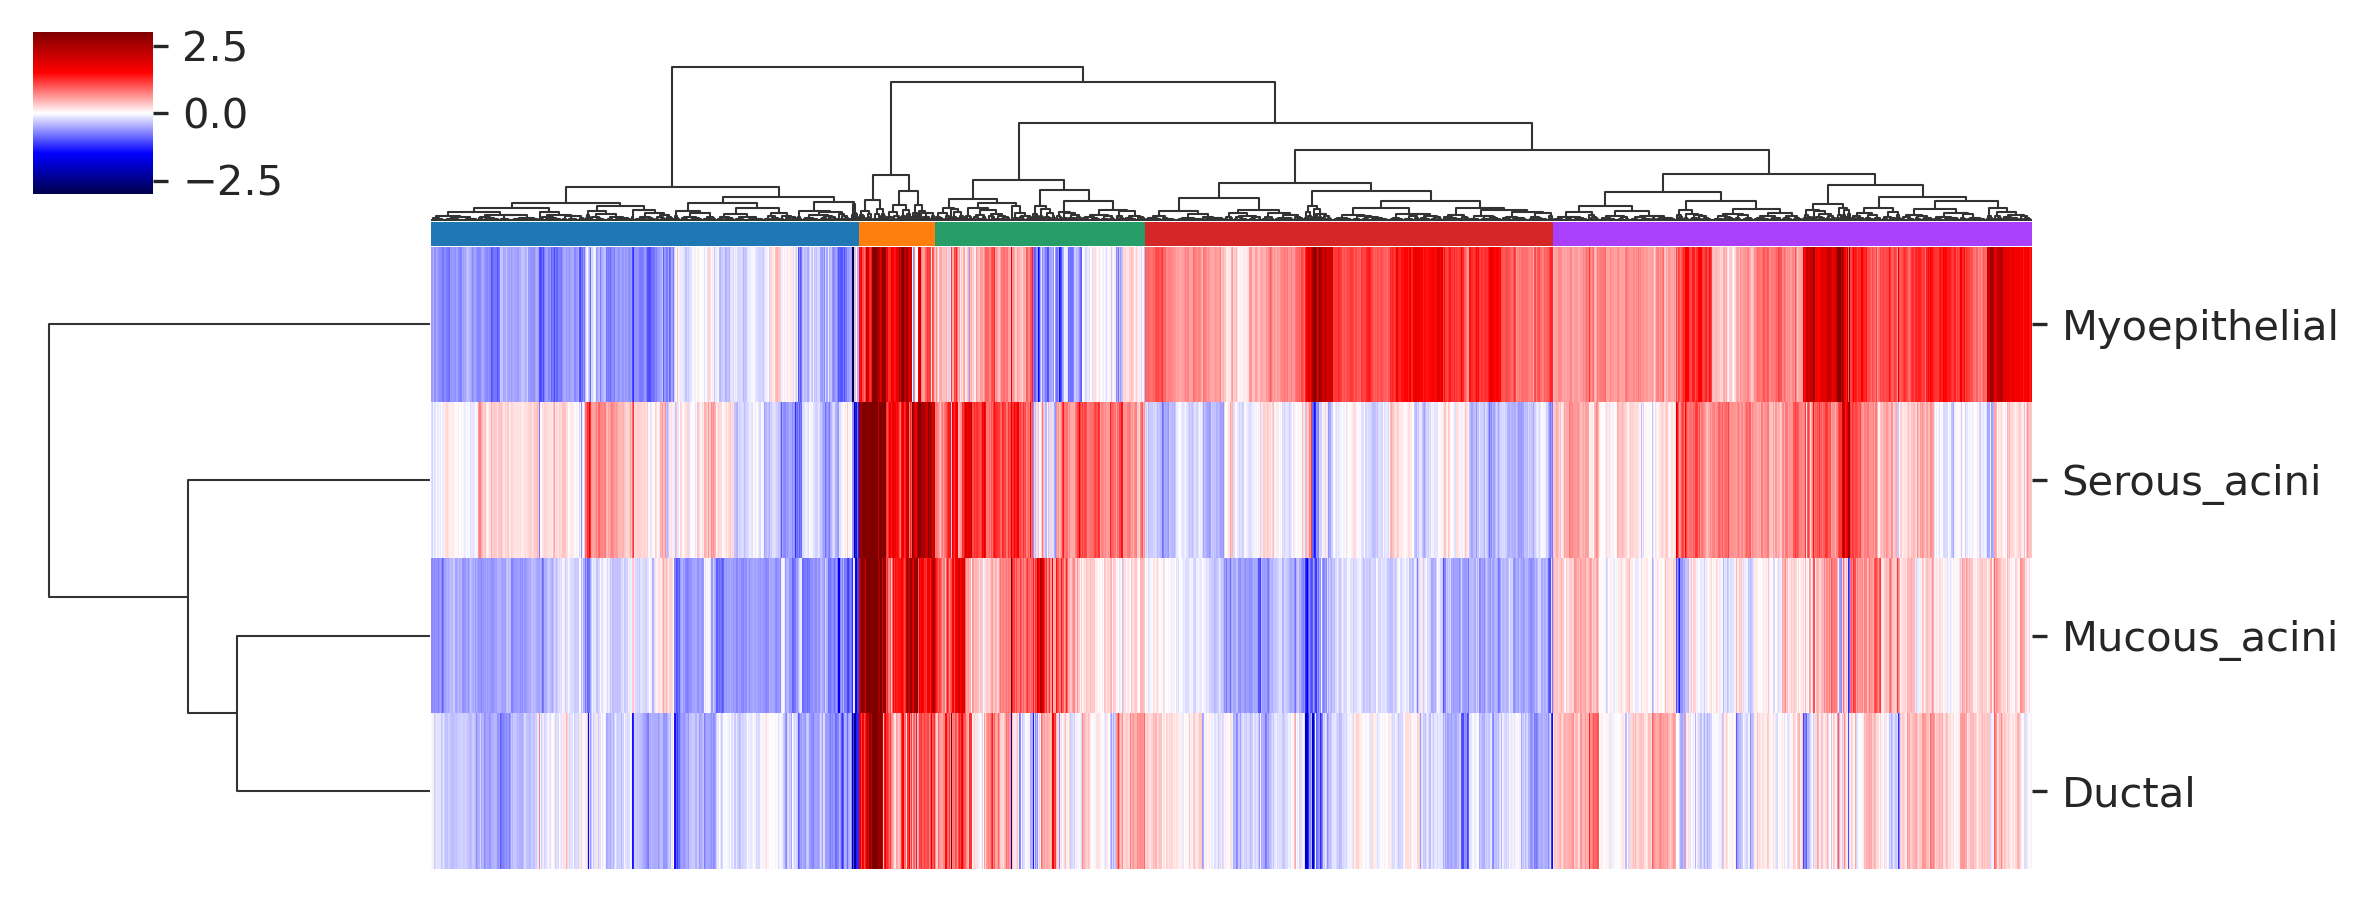

In [963]:
from scipy.cluster.hierarchy import linkage,fcluster
cx_epi_cli_state_logfc_km = np.clip(cx_epi_cli_state_all_logfc,-3,3)
# cx_epi_cli_state_logfc_km.columns = [np.nan]*len(cx_epi_cli_state_logfc_km.columns)
col_linkage = linkage(cx_epi_cli_state_logfc_km.T,method='ward')
col_clusters = fcluster(col_linkage,t=5,criterion='maxclust',depth=2)
# col_clusters = col_clusters[np.argsort(col_clusters)]
col_colors_map = sns.color_palette(n_colors=5)
col_colors = [col_colors_map[i-1] for i in col_clusters]
# cx_epi_cli_state_logfc_km = cx_epi_cli_state_logfc.iloc[:,np.argsort(col_clusters)]
g=sns.clustermap(cx_epi_cli_state_logfc_km,col_colors=col_colors,col_linkage=col_linkage,yticklabels=True,xticklabels=False,cmap='seismic',center=0,figsize=(8,3),col_cluster=True,row_cluster=True)
# plt.savefig('cx_epi_results/clustermap_cx_epi_major_cli_state_all_logfc.pdf',bbox_inches='tight',dpi=300)

In [23]:
up_go = pd.read_csv('../scripts/CX_20211030/cx_epi_results/s04_epi_major_up_deg_logfc05_df_HeatmapSelectedGOTop100.csv',index_col=0)
up_go.index = up_go.Description
up_go = up_go.iloc[:,1:]
up_go.columns = ['_'.join(c.split('_')[2:]) for c in up_go.columns]
up_go = up_go.loc[:,['Serous_acini','Mucous_acini','Ductal','Myoepithelial']]
up_go_df_list = []
for c in up_go.columns:
    up_go_df_list.append(up_go.sort_values(by=c).head(30))
up_go_top5 = pd.concat(up_go_df_list,axis=0).drop_duplicates()
down_go = pd.read_csv('../scripts/CX_20211030/cx_epi_results/s04_epi_major_down_deg_logfc05_df_HeatmapSelectedGOTop100.csv',index_col=0)
down_go.index = down_go.Description
down_go = down_go.iloc[:,1:]
down_go.columns = ['_'.join(c.split('_')[2:]) for c in down_go.columns]
down_go = down_go.loc[:,['Serous_acini','Mucous_acini','Ductal','Myoepithelial']]
down_go_df_list = []
for c in down_go.columns:
    down_go_df_list.append(down_go.sort_values(by=c).head(20))
down_go_top5 = pd.concat(down_go_df_list,axis=0).drop_duplicates()

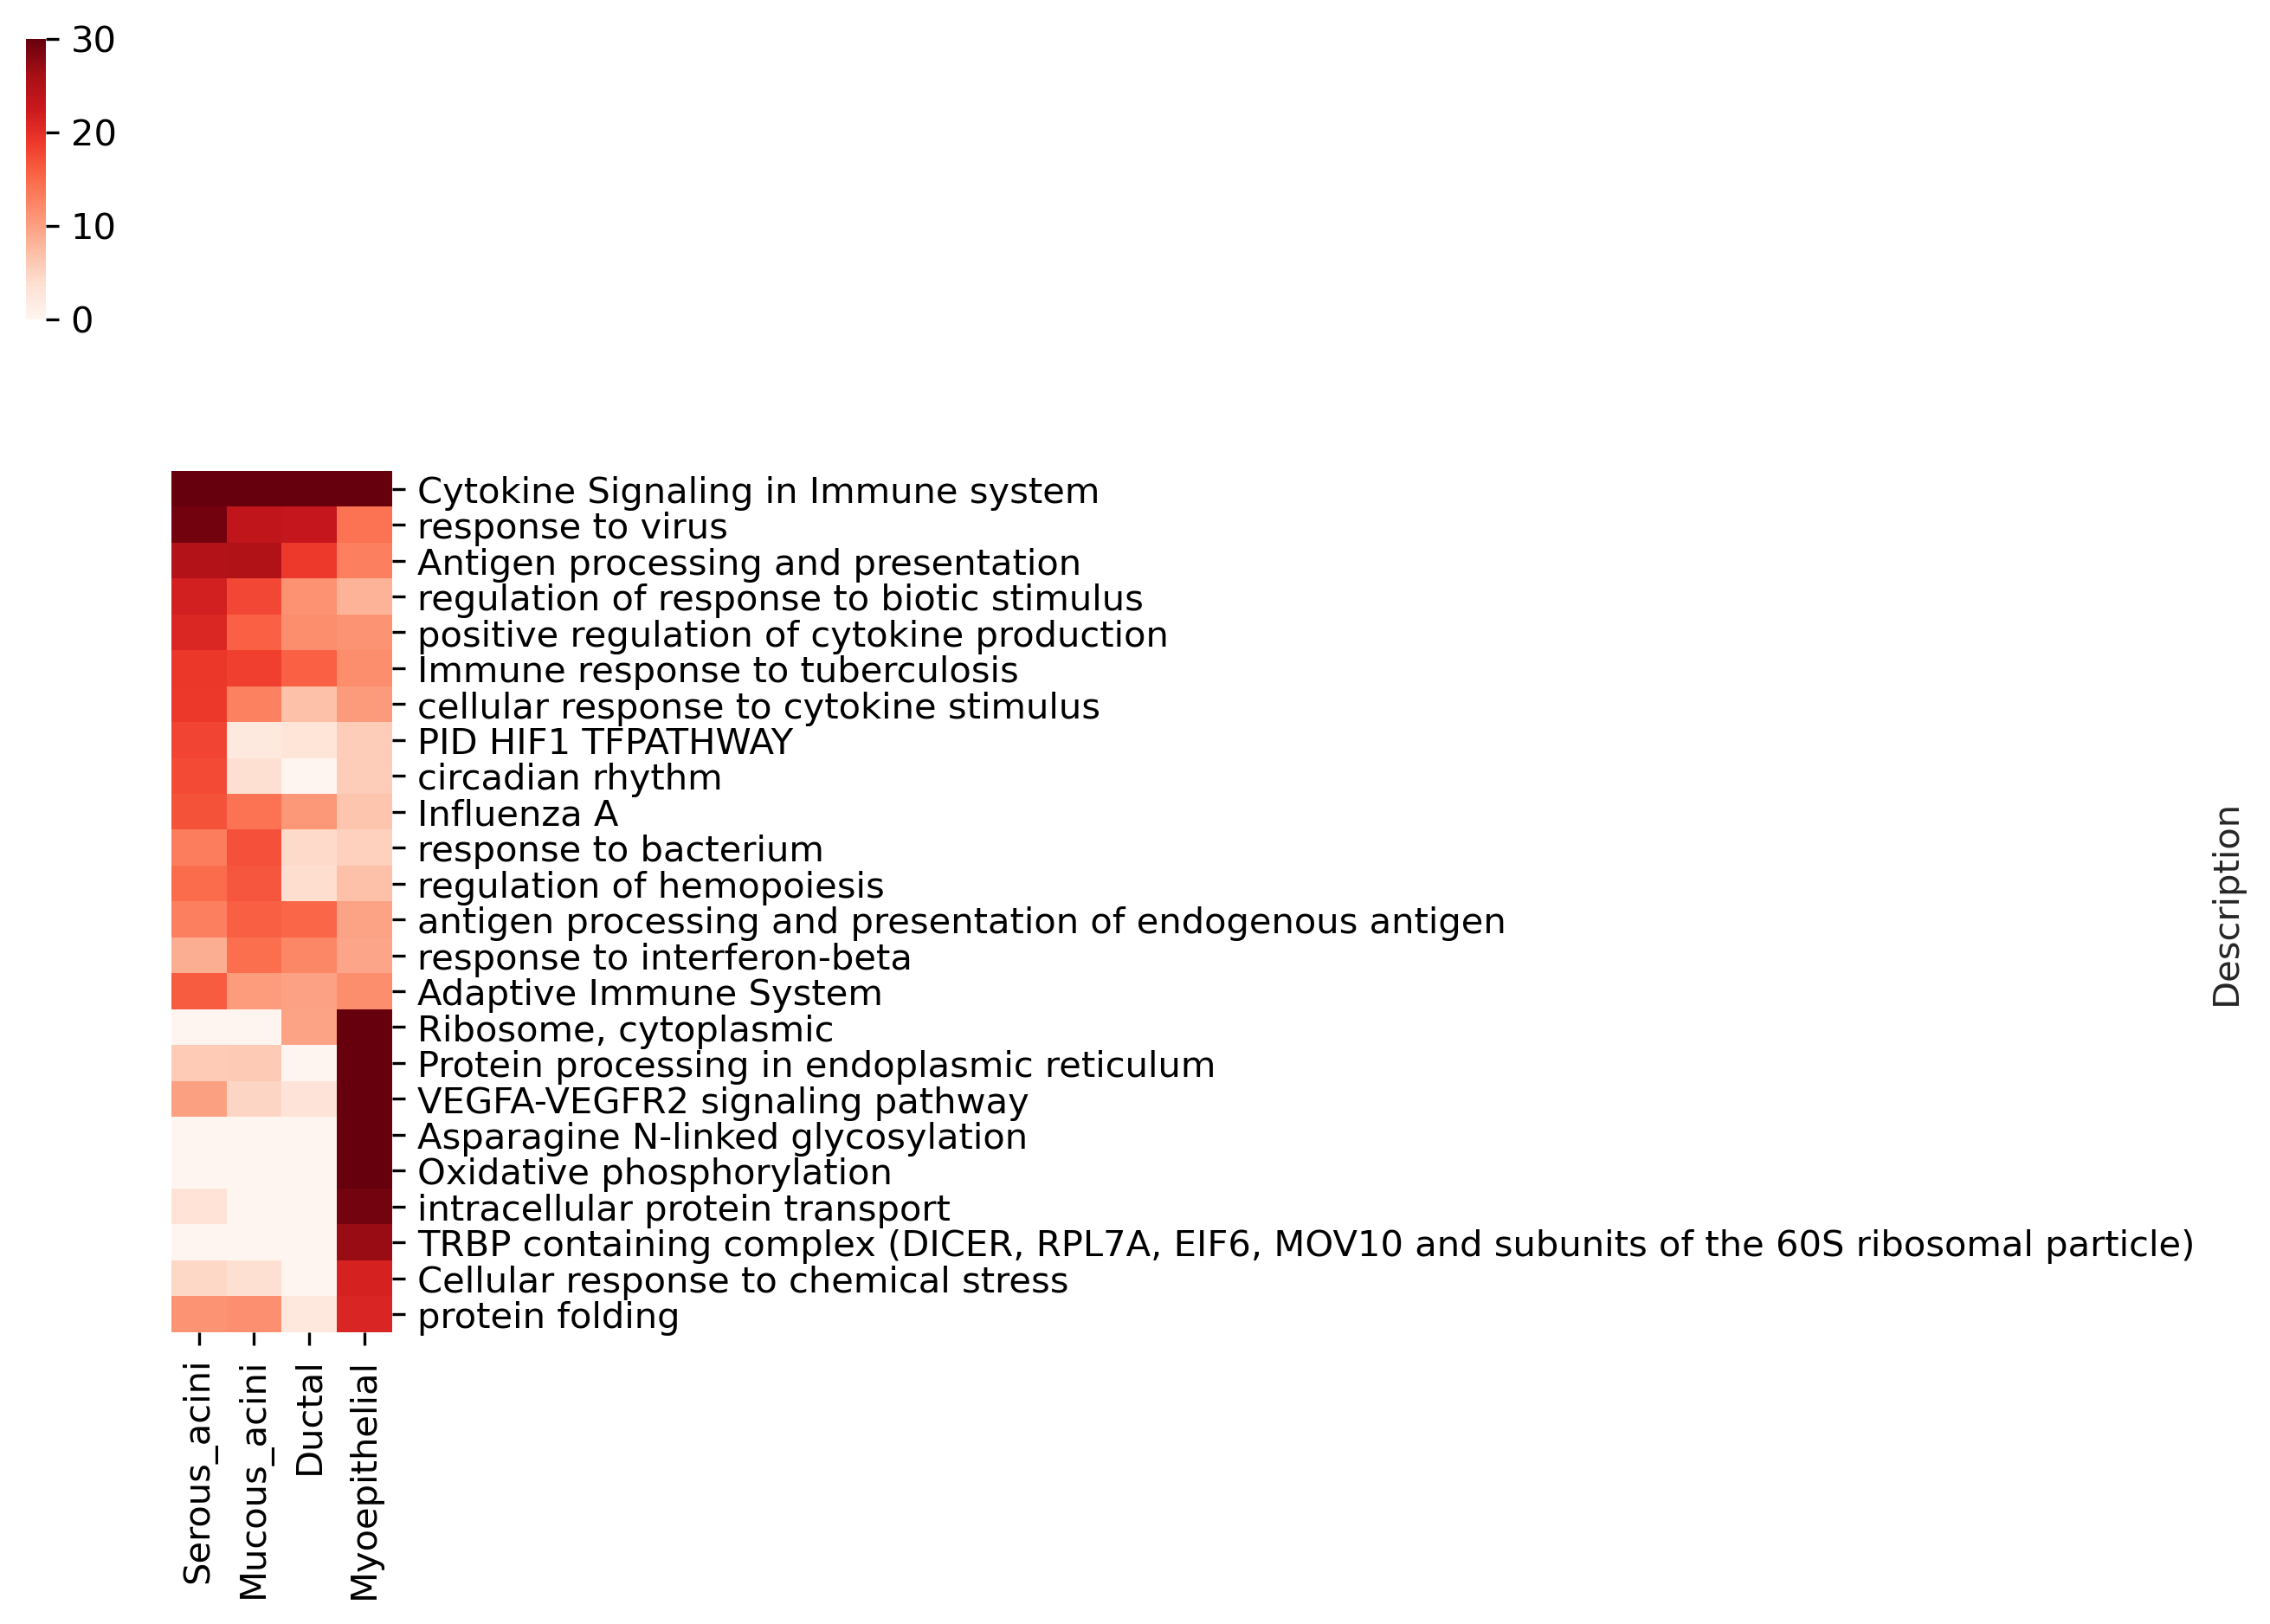

In [711]:
sns.clustermap(-up_go_top5,row_cluster=False,col_cluster=False,cmap='Reds',vmax=30,figsize=(1.5,6),yticklabels=True)
plt.savefig('cx_epi_results/clustermap_cx_epi_major_cli_state_up_logfc_goterm.pdf',bbox_inches='tight',dpi=300)

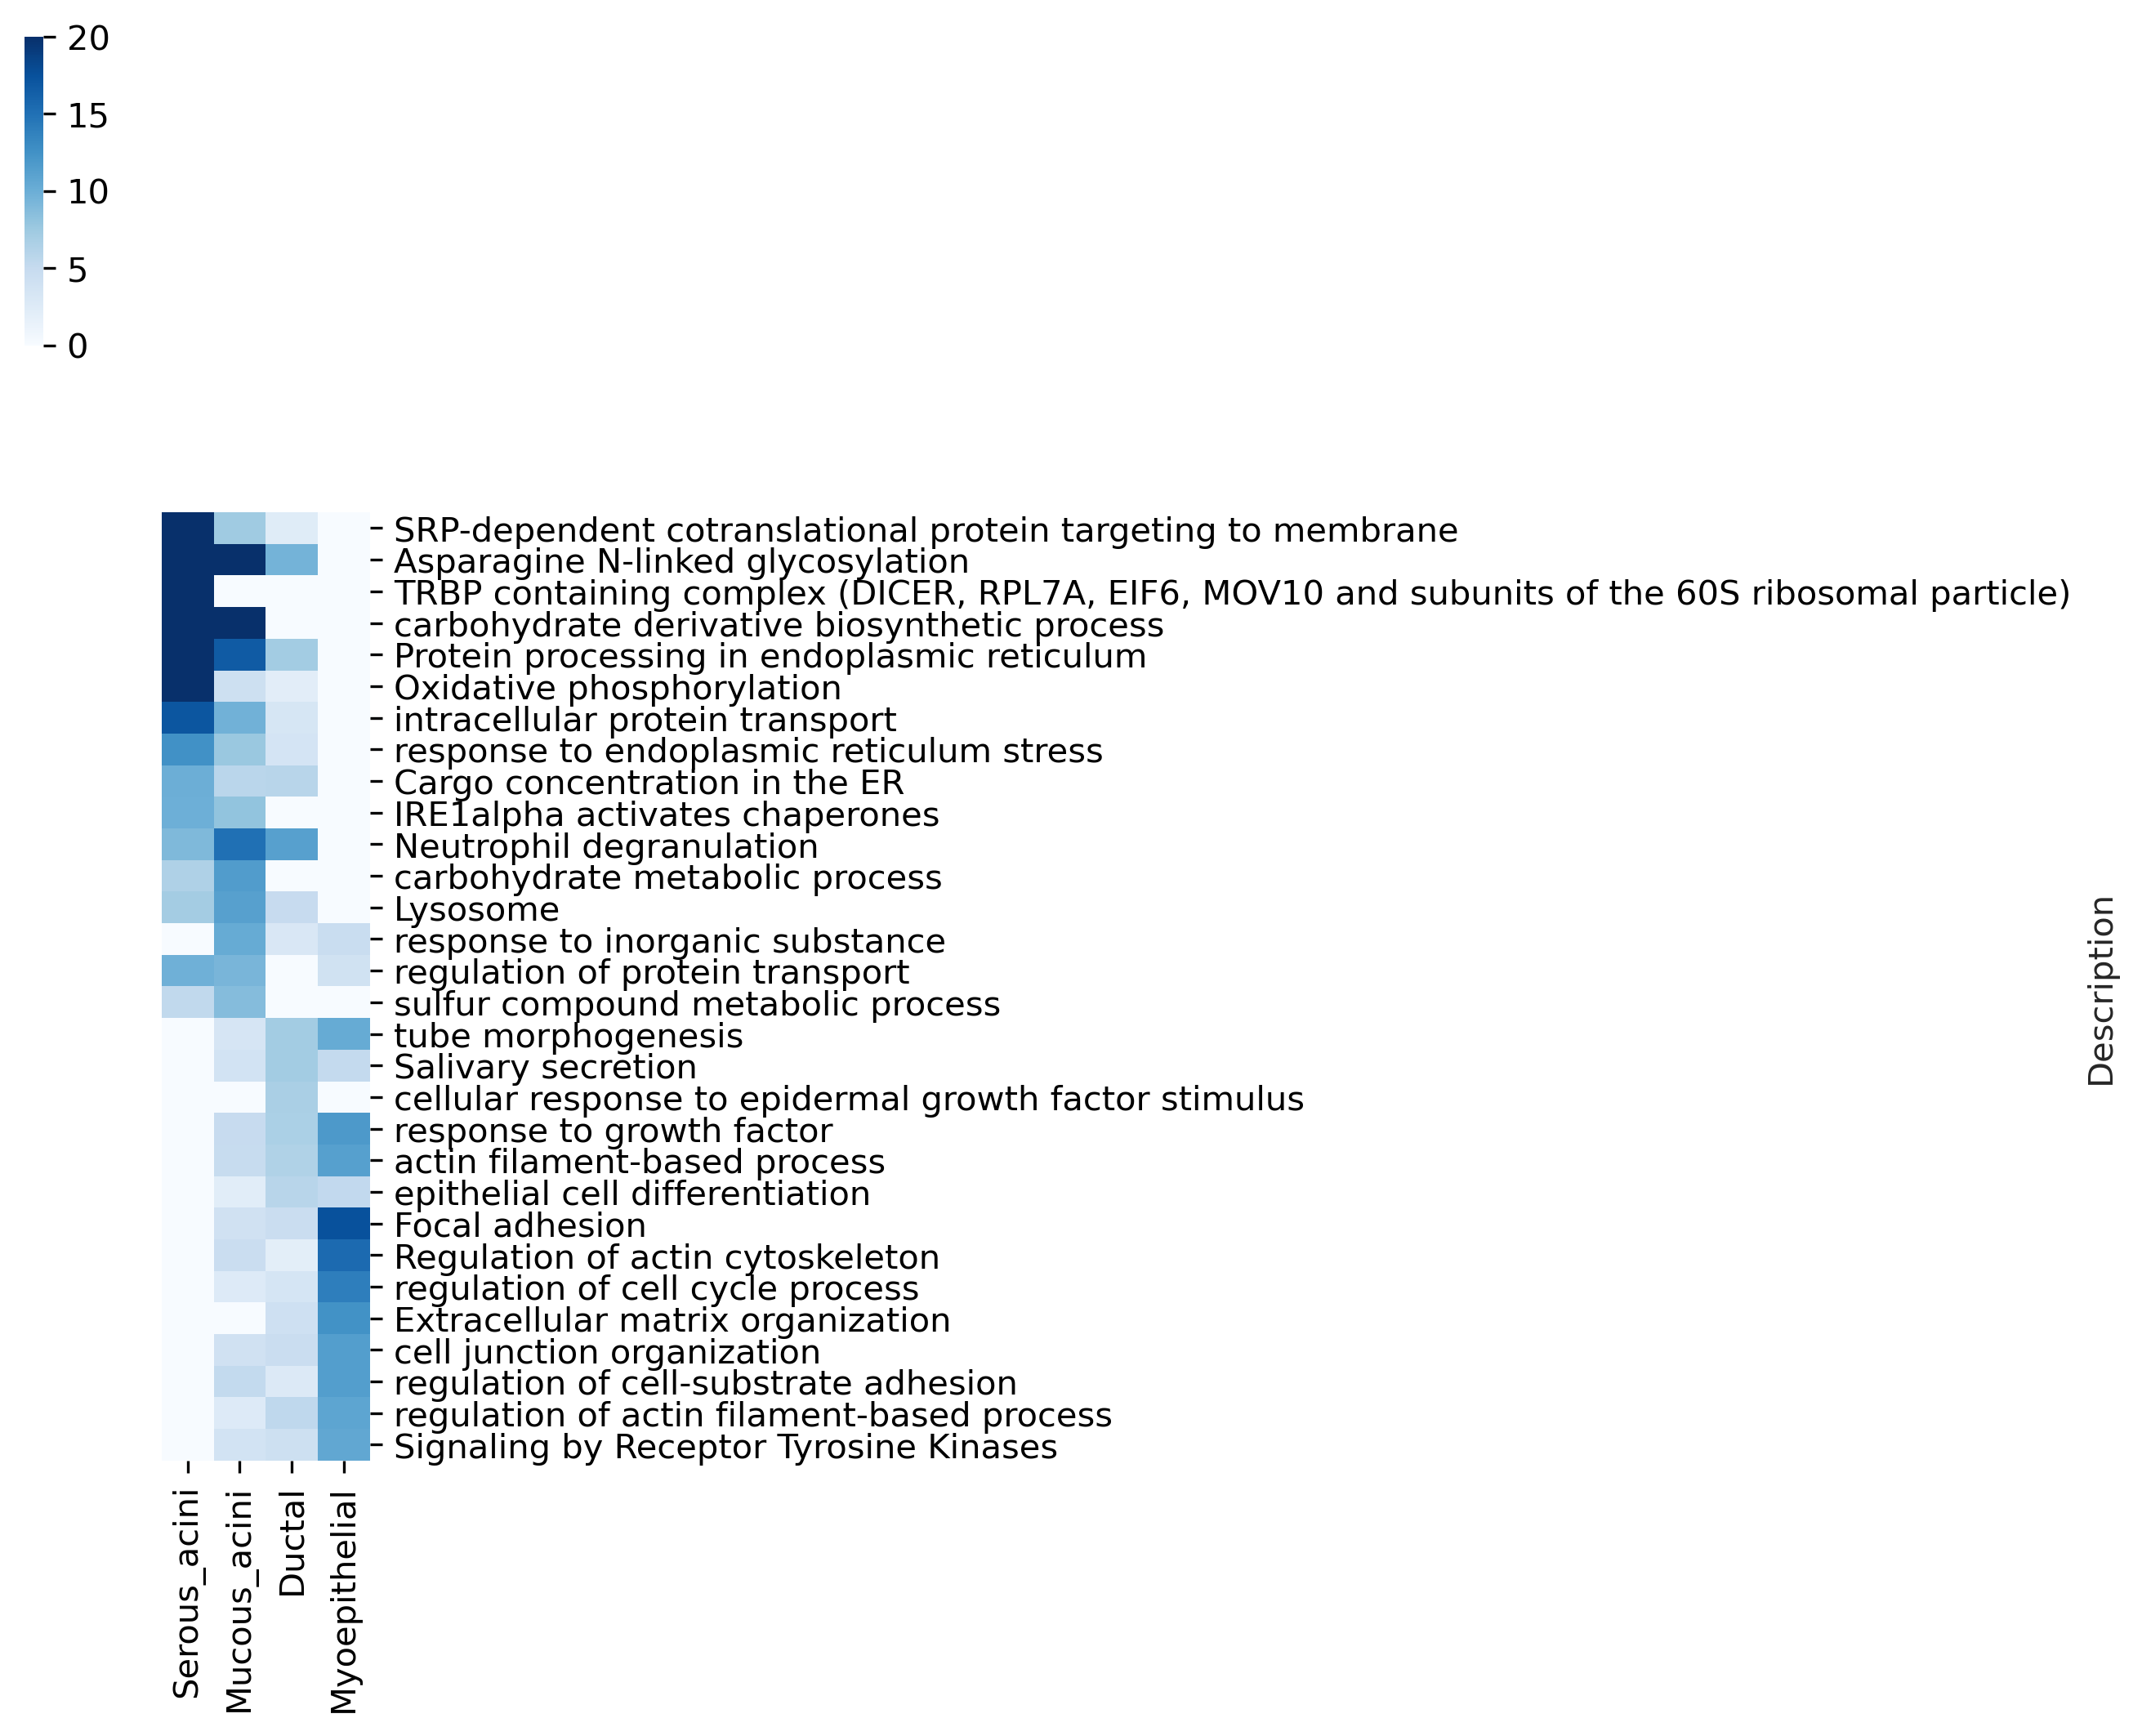

In [713]:
sns.clustermap(-down_go_top5,row_cluster=False,col_cluster=False,cmap='Blues',vmax=20,figsize=(1.5,7),yticklabels=True)
plt.savefig('cx_epi_results/clustermap_cx_epi_major_cli_state_down_logfc_goterm.pdf',bbox_inches='tight',dpi=300)

In [26]:
terms = ['Antigen processing and presentation','response to interferon-beta','Oxidative phosphorylation','Salivary secretion', 'regulation of cell cycle process', 'epithelial cell differentiation']

In [27]:
term_path = [
    '/home/qukun/xuhao/workspace/Sjs/scripts/CX_20211030/cx_epi_results/KEGG_hsa04612_Antigen processing and presentation.txt',
    '/home/qukun/xuhao/workspace/Sjs/scripts/CX_20211030/cx_epi_results/GO_response to interferon-beta.txt',
    '/home/qukun/xuhao/workspace/Sjs/scripts/CX_20211030/cx_epi_results/KEGG_hsa00190_Oxidative phosphorylation.txt',
    '/home/qukun/xuhao/workspace/Sjs/scripts/CX_20211030/cx_epi_results/KEGG_hsa04970_Salivary secretion.txt',
    '/home/qukun/xuhao/workspace/Sjs/scripts/CX_20211030/cx_epi_results/GO_regulation of cell cycle process.txt',
    '/home/qukun/xuhao/workspace/Sjs/scripts/CX_20211030/cx_epi_results/GO_epithelial cell differentiation.txt'
]

In [28]:
term_df = pd.DataFrame(index=terms,columns=['gene'])
for i,path in enumerate(term_path):
    term_gene_df = pd.read_csv(path,sep='\t',header=None)
    term_genes = [g.split(';')[0] for g in term_gene_df.iloc[:,1].values]
    term_df.loc[terms[i],'gene'] =  term_genes

In [29]:
for term in term_df.index:
    genes = np.intersect1d(term_df.loc[term,'gene'],cx_epi.var_names)
    sc.tl.score_genes(cx_epi,genes,score_name=term,use_raw=False)
    cx_epi.obs[term+'_expr'] = cx_epi[:,genes].to_df().mean(axis=1).values

computing score 'Antigen processing and presentation'


/home/qukun/xuhao/miniconda3/envs/STACK/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'Antigen processing and presentation', score of gene set (adata.obs).
    849 total control genes are used. (0:00:02)
computing score 'response to interferon-beta'


/home/qukun/xuhao/miniconda3/envs/STACK/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'response to interferon-beta', score of gene set (adata.obs).
    499 total control genes are used. (0:00:01)
computing score 'Oxidative phosphorylation'


/home/qukun/xuhao/miniconda3/envs/STACK/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'Oxidative phosphorylation', score of gene set (adata.obs).
    749 total control genes are used. (0:00:01)
computing score 'Salivary secretion'


/home/qukun/xuhao/miniconda3/envs/STACK/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'Salivary secretion', score of gene set (adata.obs).
    999 total control genes are used. (0:00:01)
computing score 'regulation of cell cycle process'


/home/qukun/xuhao/miniconda3/envs/STACK/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'regulation of cell cycle process', score of gene set (adata.obs).
    978 total control genes are used. (0:00:01)
computing score 'epithelial cell differentiation'


/home/qukun/xuhao/miniconda3/envs/STACK/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'epithelial cell differentiation', score of gene set (adata.obs).
    1031 total control genes are used. (0:00:01)


In [35]:
cx_epi.obs[['celltype_major','cli_state']+[term+'_expr' for term in term_df.index]].to_csv('source_data/source_data_fig2d&e.csv')

/home/qukun/xuhao/miniconda3/envs/sjs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


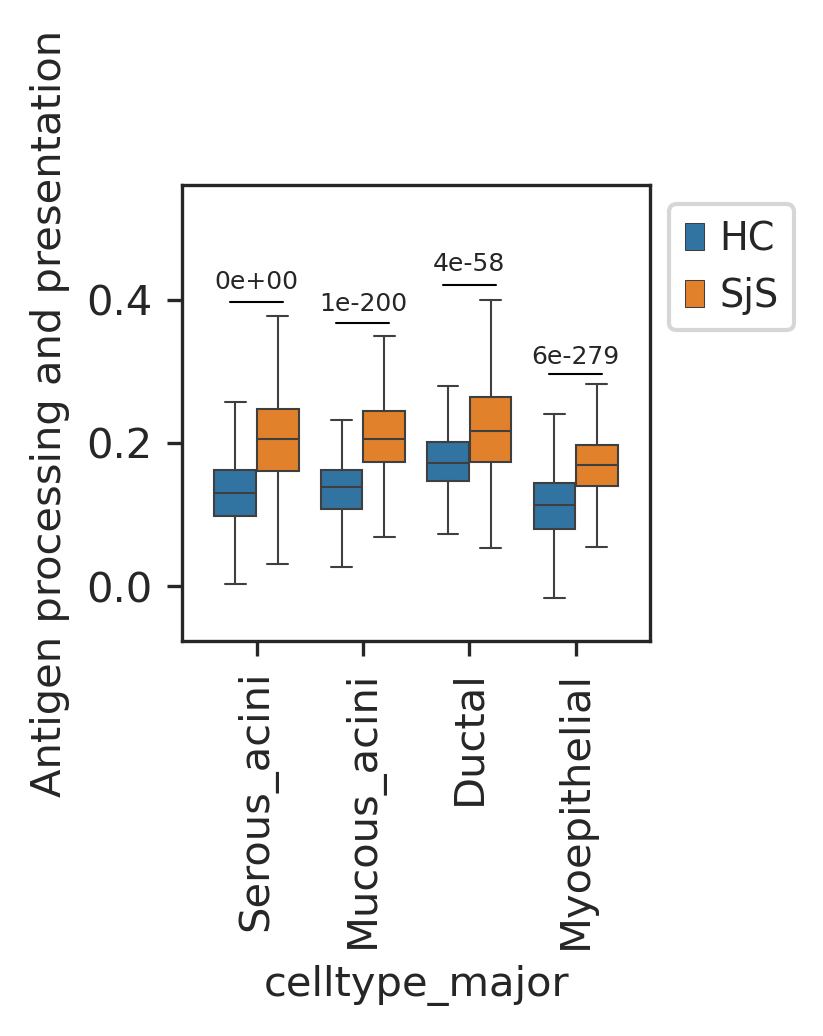

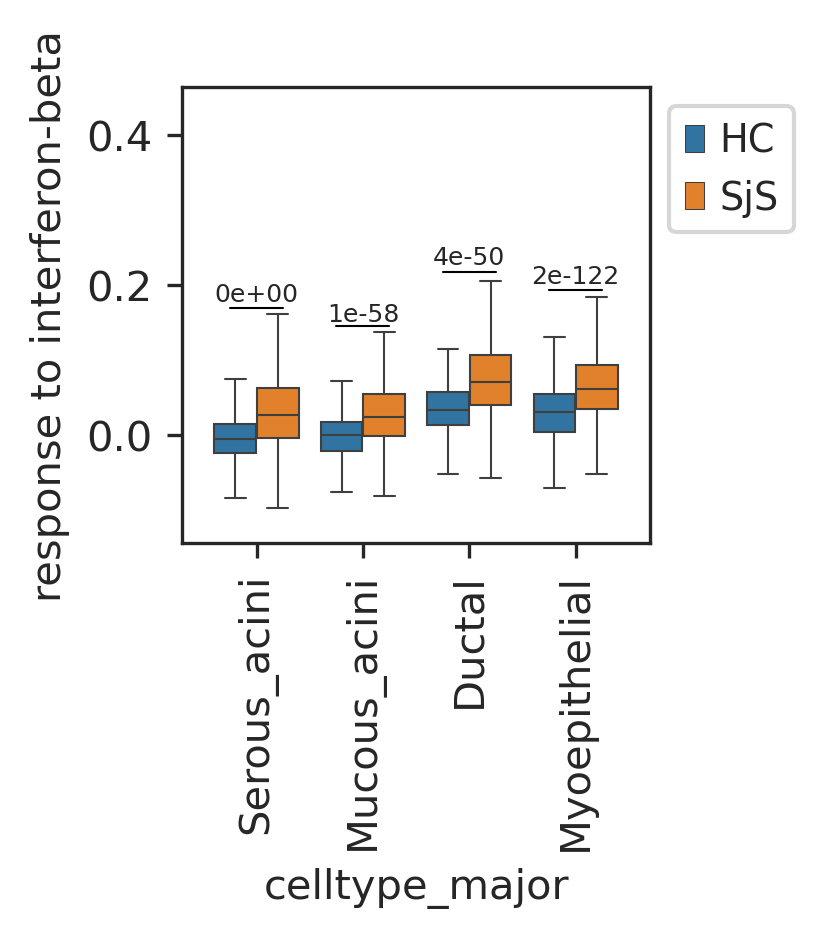

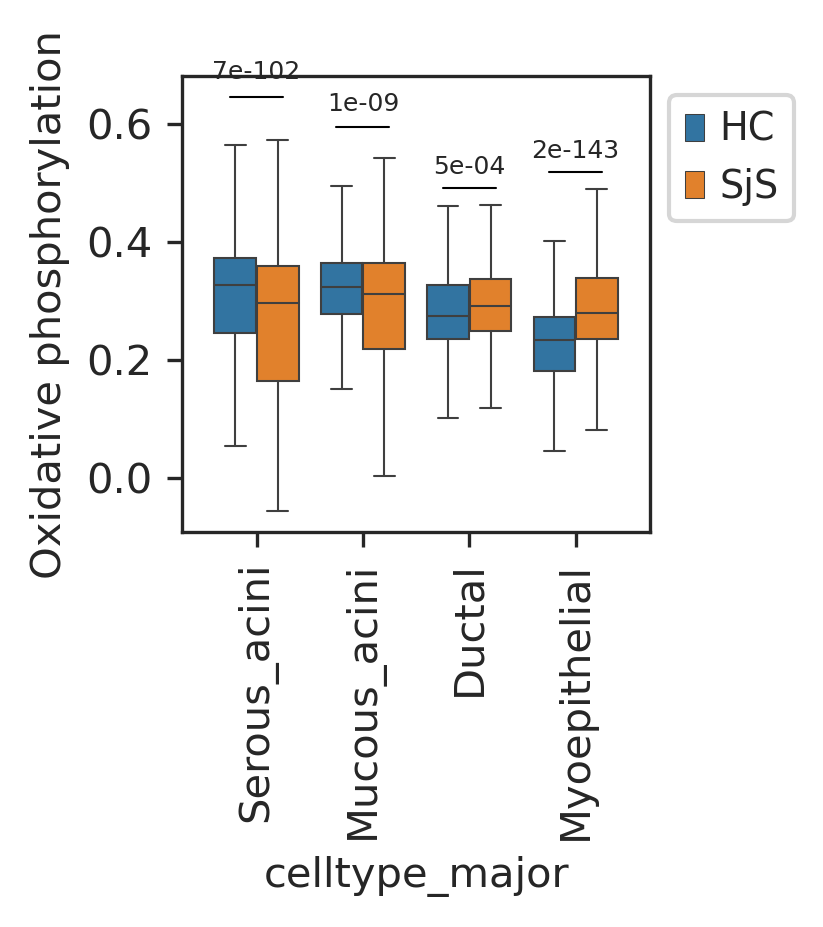

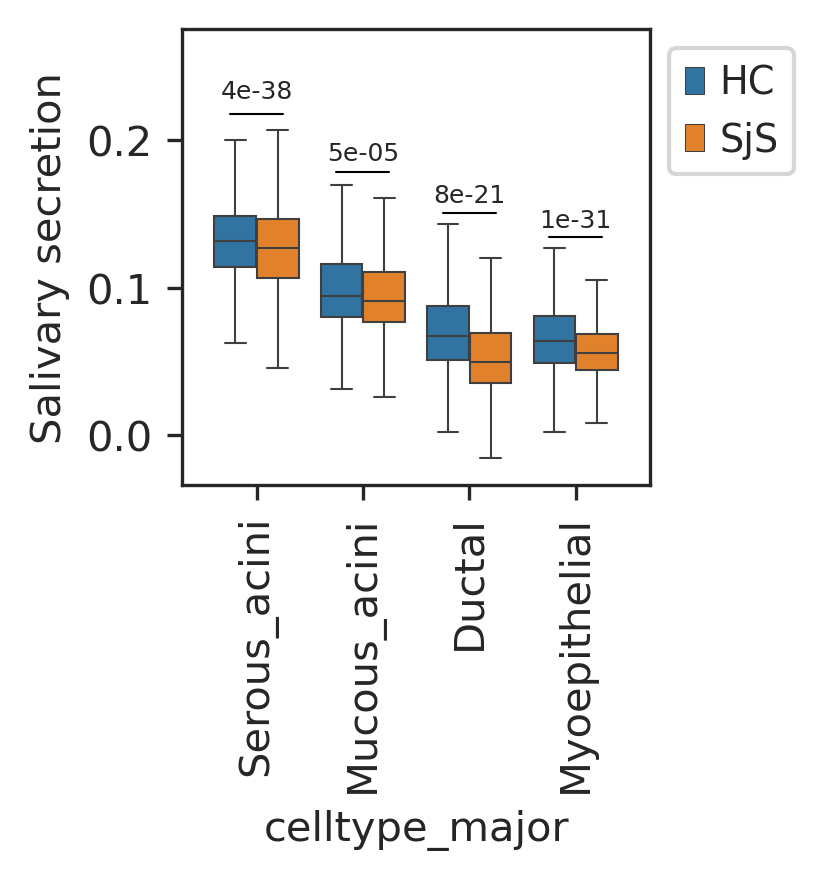

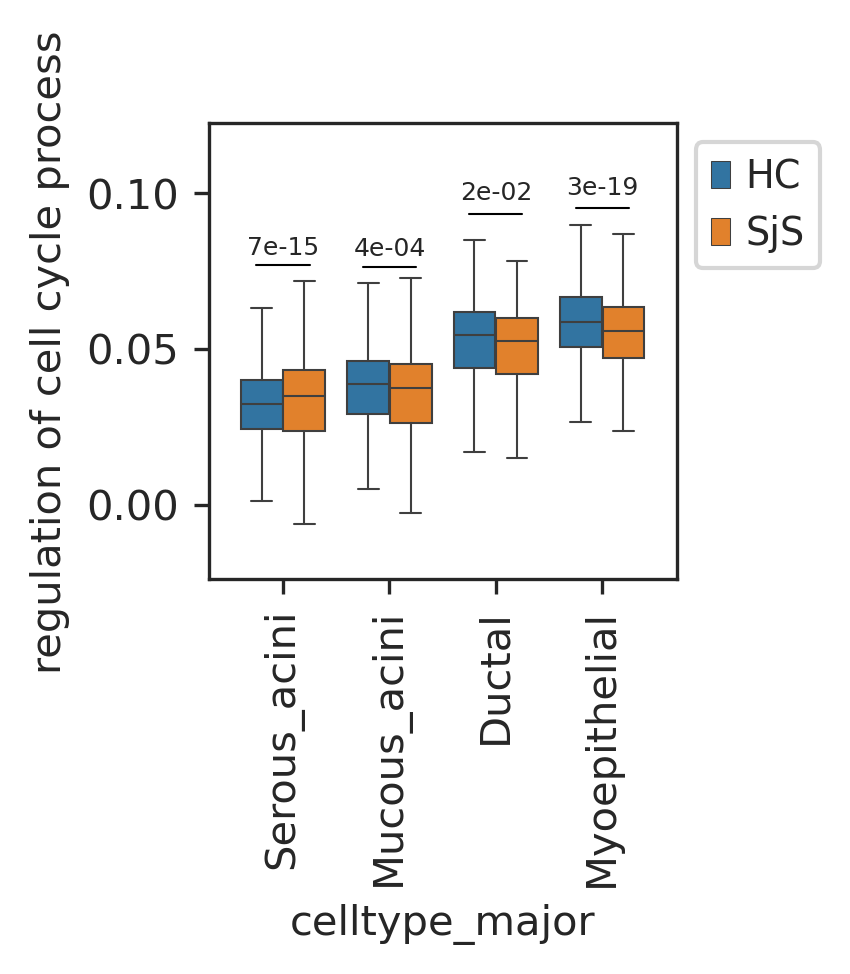

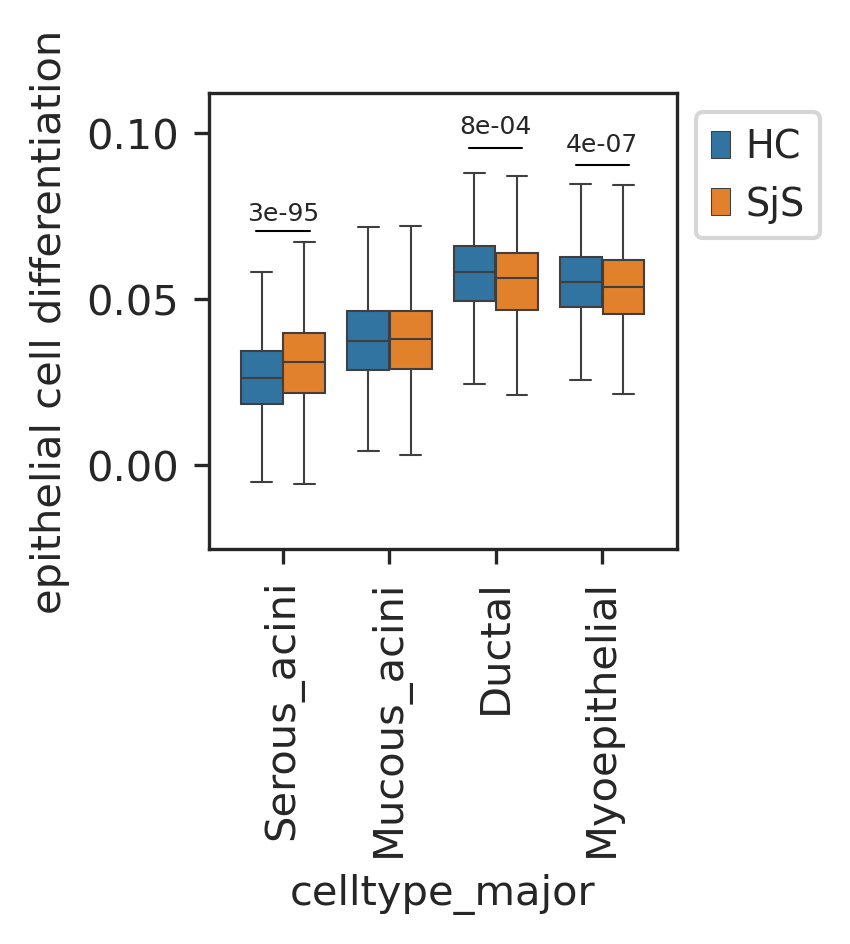

In [38]:
from scipy.stats import ranksums,ttest_ind,ttest_rel
sns.set_style('ticks')
for term in term_df.index:
    fig,ax=plt.subplots(figsize=(2,2))
    data = cx_epi.obs[['celltype_major',term,'cli_state']]
    expr_data = cx_epi.obs[['celltype_major',term+'_expr','cli_state']]
    sns.boxplot(data=data,x='celltype_major',y=term,fliersize=0,hue='cli_state',linewidth=.5,whis=1.5)
    # sns.boxplot(data=expr_data,x='celltype_major',y=term+'_expr',fliersize=0,hue='cli_state',linewidth=.5,whis=1.5)
    Q3 = data.groupby(['celltype_major','cli_state']).quantile(.75)
    Q1 = data.groupby(['celltype_major','cli_state']).quantile(.25)
    IQR = Q3 - Q1
    dmax = data.groupby(['celltype_major']).max()
    logfc = data.groupby(['celltype_major']).max()
    vmax = Q3 + 1.5 * IQR
    vmin = Q1 - 1.5 * IQR
    height = vmax.reset_index().groupby('celltype_major').max()
    for x,i in enumerate(height.index):
        # log2fc=np.log2(expr_data.loc[(expr_data['celltype_major'] == i)].groupby('cli_state').mean().loc['SjS']/expr_data.loc[(expr_data['celltype_major'] == i)].groupby('cli_state').mean().loc['HC']).values[0]
        # p = ttest_ind(expr_data.loc[(expr_data['celltype_major'] == i)&(expr_data['cli_state'] == 'SjS'),term+'_expr'].values,expr_data.loc[(expr_data['celltype_major'] == i)&(expr_data['cli_state'] == 'HC'),term+'_expr'].values)[1]
        log2fc=np.log2(data.loc[(data['celltype_major'] == i)].groupby('cli_state').mean().loc['SjS']/data.loc[(data['celltype_major'] == i)].groupby('cli_state').mean().loc['HC']).values[0]
        p = ttest_ind(data.loc[(data['celltype_major'] == i)&(data['cli_state'] == 'SjS'),term].values,data.loc[(data['celltype_major'] == i)&(data['cli_state'] == 'HC'),term].values)[1]
        if p < 0.05:
            h = min(height.loc[i].values[0],dmax.loc[i].values[0])
            d = min(height.loc[i].values[0],dmax.loc[i].values[0])/20
            plt.plot((x-.25,x+.25),(h+d,h+d),linewidth=.5,color='black')
            # plt.text(x,h,s=''.join(['*']*int(np.clip(np.floor(-np.log10(p)),0,4))),horizontalalignment='center',fontsize=6)
            # plt.text(x,h+0.15,s=round(log2fc,2),horizontalalignment='center',fontsize=6)
            plt.text(x,h+2*d,s='%.0e' % p,horizontalalignment='center',fontsize=6)
            
    plt.xticks(rotation=90)
    # plt.ylim(-0.5,1.5)
    plt.legend(bbox_to_anchor=(1,1))
    plt.savefig(f'cx_epi_results/boxplot_cx_epi_celltype_major_cli_state_all_{term}.pdf',bbox_inches='tight')

In [37]:
cx_motif = pd.read_csv('../scripts/CX_20211030/scenic_outputs/v0.12.cx.motif.csv')
cx_motif.columns = np.concatenate([cx_motif.loc[1][:2].values,cx_motif.loc[0][2:].values])
cx_motif = cx_motif.iloc[2:,:]

In [39]:
cx_motif.to_csv('source_data/source_data_fig2f.csv')

In [10]:
cx_motif.index = cx_motif.TF

In [11]:
cx_motif = cx_motif[(cx_motif['Annotation'] == 'gene is directly annotated') | (cx_motif['Annotation'].str.startswith('gene is orthologous to') & cx_motif['Annotation'].str.endswith('which is directly annotated for motif'))]

In [12]:
df_list = []
for i in range(len(cx_motif.index)):
    for item in cx_motif.iloc[i,:].TargetGenes[2:-2].split('), ('):
        target,score = item.split(', ')
        df_list.append([cx_motif.index[i],target[1:-1],score,])

In [13]:
target_df = pd.DataFrame(df_list)
target_df.columns = ['TF','target','score']

In [343]:
# target_df.index = target_df.TF

In [14]:
target_df['score'] = target_df['score'].astype('float')

In [15]:
target_df['count'] = 1

In [52]:
cmap = plt.get_cmap('Reds')

<ipython-input-87-e77fe9221e3c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_sum['count'] = 1


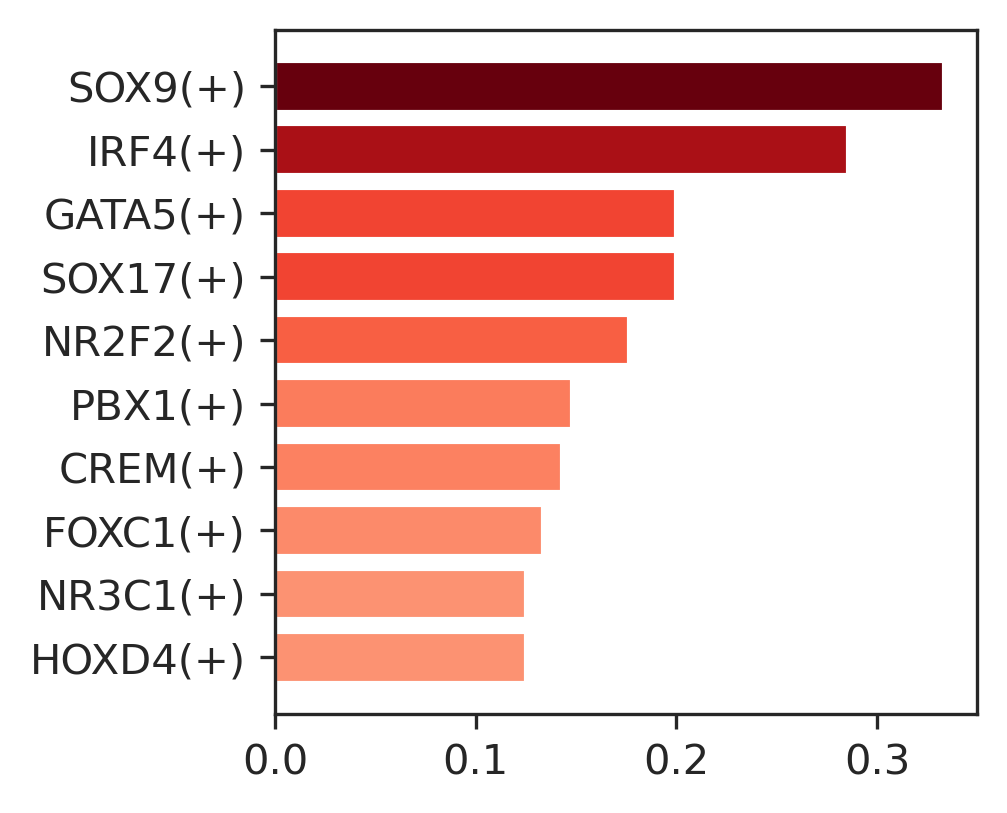

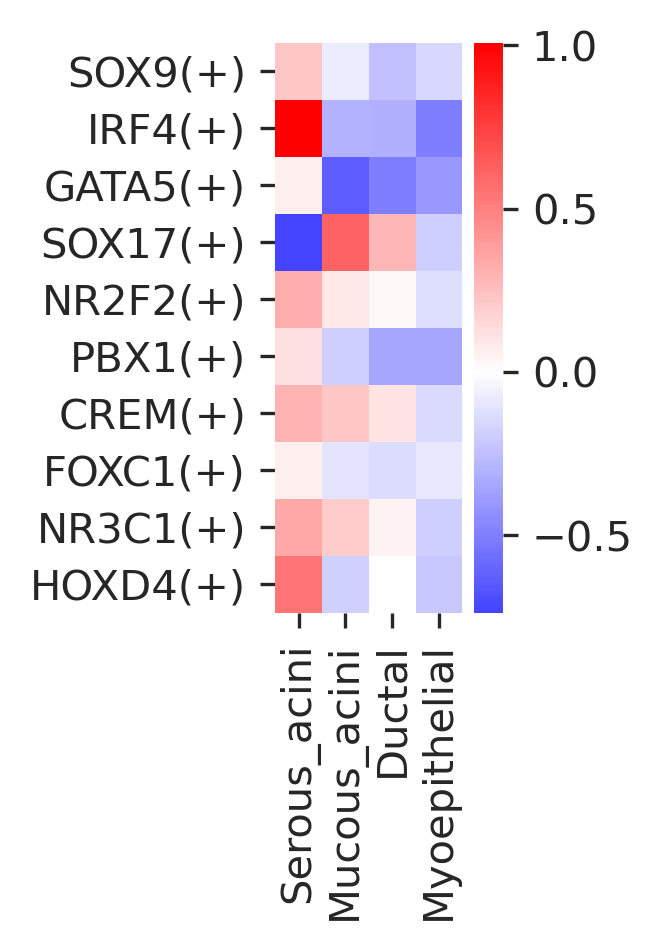

In [87]:
tf_sorted = target_df[target_df['target'].isin(term_df.loc['epithelial cell differentiation','gene'])].groupby(['TF','target']).max().reset_index()
tf_sorted = tf_sorted.groupby('TF')['score'].mean().sort_values()[::-1]
tf_sum = target_df[target_df['target'].isin(term_df.loc['epithelial cell differentiation','gene'])]
tf_sum['count'] = 1
tf_sum = tf_sum.groupby(['TF','target']).max().reset_index().groupby('TF')['count'].sum()
tf_prop = (tf_sum/target_df.groupby(['TF','target']).max().reset_index().groupby('TF').sum().loc[tf_sum.index,'count']).sort_values()[::-1]
tf_prop.index = [ind+'(+)' for ind in tf_prop.index]
tf_prop_head = tf_prop.loc[np.intersect1d(tf_prop.index,cx_epi_scenic_cli_state_logfc.columns[((cx_epi_scenic_cli_state_logfc<-0.1)&(cx_epi_scenic_cli_state_pval<0.01)).sum(0)>0].values)].sort_values(ascending=False).head(10)

sns.set_style('ticks')
plt.barh(tf_prop_head.index[::-1],tf_prop_head[::-1],color=[cmap(tf) for tf in tf_prop_head[::-1]/tf_prop_head[::-1].max()])
plt.savefig('cx_epi_results/barplot_cx_epi_scenic_tf_in_term_epithelial_cell_differentiation_target_prop.pdf',bbox_inches='tight')
plt.subplots(figsize=(1,2.5))
sns.heatmap(cx_epi_scenic_cli_state_logfc.loc[:,tf_prop_head.index].T,cmap='bwr',xticklabels=True,center=0)
plt.savefig('cx_epi_results/heatmap_cx_epi_scenic_tf_in_term_epithelial_cell_differentiation_logfc.pdf',bbox_inches='tight')

In [41]:
sox9_degs = pd.read_csv('../scripts/CX_20211030/cx_epi_results/SOX9_knockout_genes.txt',sep='\t')

sc.tl.score_genes(cx_epi,gene_list = sox9_degs[(sox9_degs['q value'] < 0.01) & (sox9_degs['log2 fold-change'] < -2)]['Gene name'].values, score_name='sox9_down',use_raw=False)
sc.tl.score_genes(cx_epi,gene_list = sox9_degs[(sox9_degs['q value'] < 0.01) & (sox9_degs['log2 fold-change'] > 2)]['Gene name'].values, score_name='sox9_up',use_raw=False)


computing score 'sox9_down'


/home/qukun/xuhao/miniconda3/envs/STACK/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'sox9_down', score of gene set (adata.obs).
    150 total control genes are used. (0:00:02)
computing score 'sox9_up'


/home/qukun/xuhao/miniconda3/envs/STACK/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'sox9_up', score of gene set (adata.obs).
    99 total control genes are used. (0:00:01)


In [43]:
sox9_degs.to_csv('source_data/source_data_fig2g.csv')

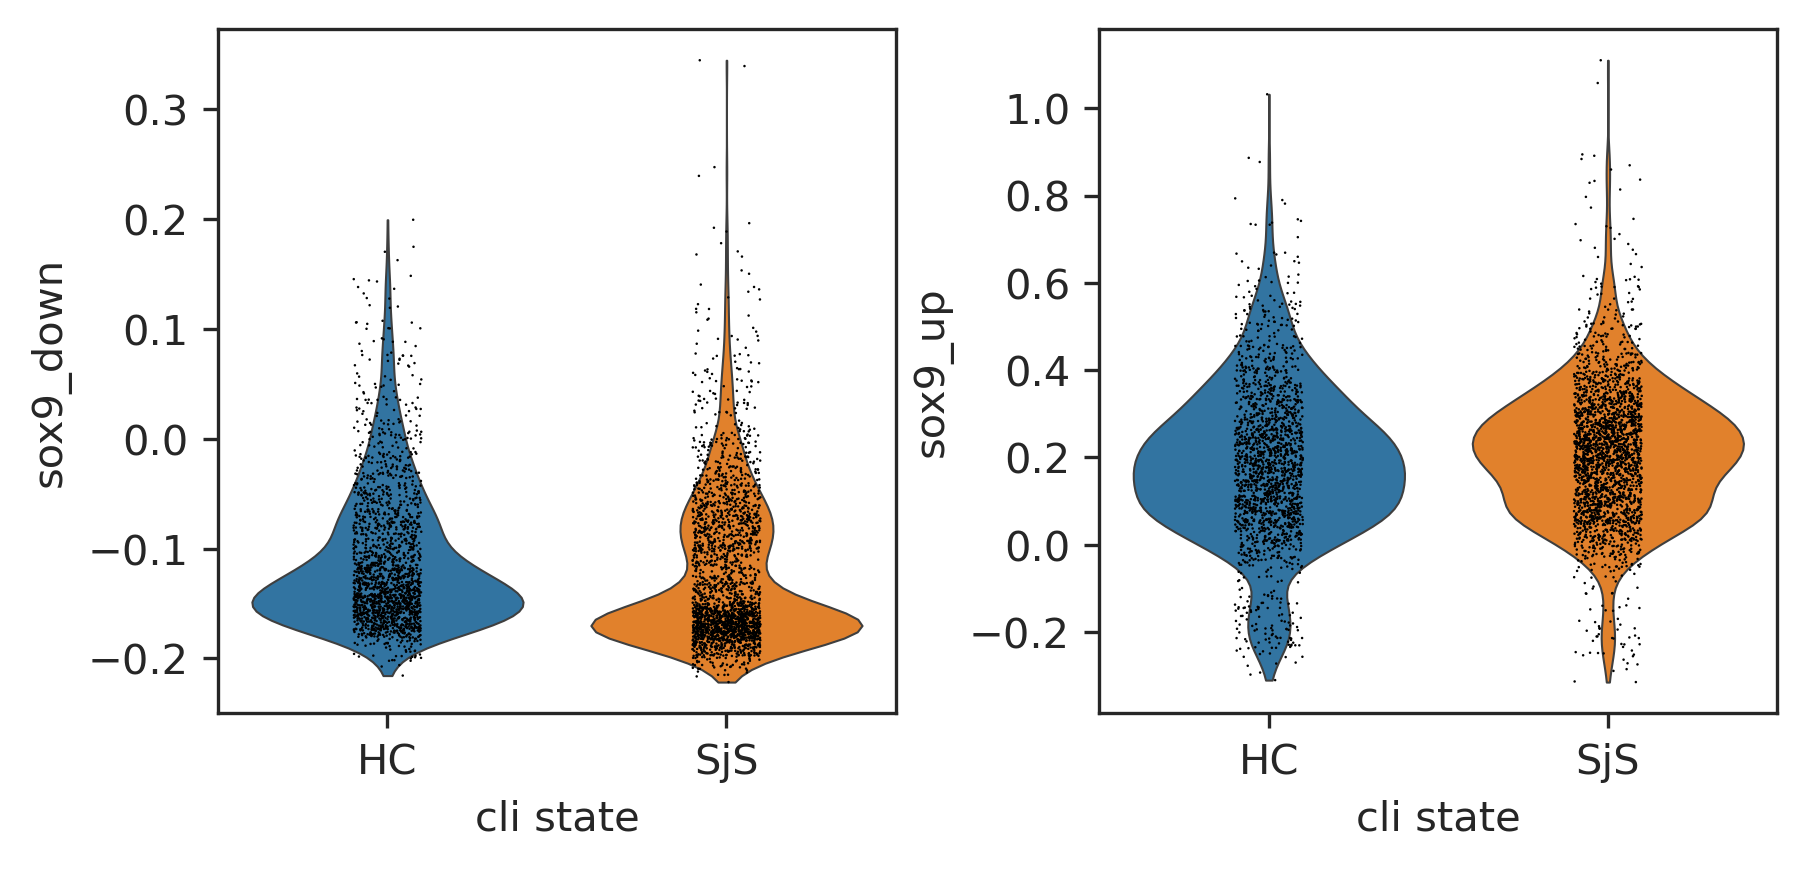

In [86]:
sns.set_style('ticks')
sc.pl.violin(cx_epi[cx_epi.obs.celltype_major=='Myoepithelial'],['sox9_down','sox9_up'],groupby='cli_state',linewidth=.5,edgecolor='black',size=.6,figsize=(5,10),save='_sox9_knockout_degs.pdf',raster=True)

In [126]:
# cx_epi_cli_state_degs_nofilter = pd.read_csv('cx_epi_results/cx_epi_cli_state_degs_nofilter.csv',index_col=0)
serous_cli_state_degs = cx_epi_cli_state_degs_nofilter[cx_epi_cli_state_degs_nofilter.celltype_major == 'Serous_acini']
serous_cli_state_degs['logpvals'] = -np.log10(serous_cli_state_degs['pvals_adj'])
serous_cli_state_degs.loc[serous_cli_state_degs['logpvals'] == np.inf,'logpvals'] = 300
serous_cli_state_degs = serous_cli_state_degs[serous_cli_state_degs['pct_nz_group'] > 0.1]
serous_cli_state_degs = serous_cli_state_degs[serous_cli_state_degs['pvals_adj'] < 0.01]
serous_cli_state_degs['color'] = '#808080'
serous_cli_state_degs.loc[(serous_cli_state_degs['logfoldchanges'] >= 0.5)&((serous_cli_state_degs['pvals_adj'] < 0.01)),'color'] = matplotlib.colors.to_hex(sns.color_palette(n_colors=2)[1])
serous_cli_state_degs.loc[(serous_cli_state_degs['logfoldchanges'] <= -0.5)&((serous_cli_state_degs['pvals_adj'] < 0.01)),'color'] = matplotlib.colors.to_hex(sns.color_palette(n_colors=2)[0])

mucous_cli_state_degs = cx_epi_cli_state_degs_nofilter[cx_epi_cli_state_degs_nofilter.celltype_major == 'Mucous_acini']
mucous_cli_state_degs['logpvals'] = -np.log10(mucous_cli_state_degs['pvals_adj'])
mucous_cli_state_degs.loc[mucous_cli_state_degs['logpvals'] == np.inf,'logpvals'] = 300
mucous_cli_state_degs = mucous_cli_state_degs[mucous_cli_state_degs['pct_nz_group'] > 0.1]
mucous_cli_state_degs = mucous_cli_state_degs[mucous_cli_state_degs['pvals_adj'] < 0.01]
mucous_cli_state_degs['color'] = '#808080'
mucous_cli_state_degs.loc[(mucous_cli_state_degs['logfoldchanges'] >= 0.5)&((mucous_cli_state_degs['pvals_adj'] < 0.01)),'color'] = matplotlib.colors.to_hex(sns.color_palette(n_colors=2)[1])
mucous_cli_state_degs.loc[(mucous_cli_state_degs['logfoldchanges'] <= -0.5)&((mucous_cli_state_degs['pvals_adj'] < 0.01)),'color'] = matplotlib.colors.to_hex(sns.color_palette(n_colors=2)[0])

duct_cli_state_degs = cx_epi_cli_state_degs_nofilter[cx_epi_cli_state_degs_nofilter.celltype_major == 'Ductal']
duct_cli_state_degs['logpvals'] = -np.log10(duct_cli_state_degs['pvals_adj'])
duct_cli_state_degs.loc[duct_cli_state_degs['logpvals'] == np.inf,'logpvals'] = 300
duct_cli_state_degs = duct_cli_state_degs[duct_cli_state_degs['pct_nz_group'] > 0.1]
duct_cli_state_degs = duct_cli_state_degs[duct_cli_state_degs['pvals_adj'] < 0.01]
duct_cli_state_degs['color'] = '#808080'
duct_cli_state_degs.loc[(duct_cli_state_degs['logfoldchanges'] >= 0.5)&((duct_cli_state_degs['pvals_adj'] < 0.01)),'color'] = matplotlib.colors.to_hex(sns.color_palette(n_colors=2)[1])
duct_cli_state_degs.loc[(duct_cli_state_degs['logfoldchanges'] <= -0.5)&((duct_cli_state_degs['pvals_adj'] < 0.01)),'color'] = matplotlib.colors.to_hex(sns.color_palette(n_colors=2)[0])

myoepi_cli_state_degs = cx_epi_cli_state_degs_nofilter[cx_epi_cli_state_degs_nofilter.celltype_major == 'Myoepithelial']
myoepi_cli_state_degs['logpvals'] = -np.log10(myoepi_cli_state_degs['pvals_adj'])
myoepi_cli_state_degs.loc[myoepi_cli_state_degs['logpvals'] == np.inf,'logpvals'] = 300
myoepi_cli_state_degs = myoepi_cli_state_degs[myoepi_cli_state_degs['pct_nz_group'] > 0.1]
myoepi_cli_state_degs = myoepi_cli_state_degs[myoepi_cli_state_degs['pvals_adj'] < 0.01]
myoepi_cli_state_degs['color'] = '#808080'
myoepi_cli_state_degs.loc[(myoepi_cli_state_degs['logfoldchanges'] >= 0.5)&((myoepi_cli_state_degs['pvals_adj'] < 0.01)),'color'] = matplotlib.colors.to_hex(sns.color_palette(n_colors=2)[1])
myoepi_cli_state_degs.loc[(myoepi_cli_state_degs['logfoldchanges'] <= -0.5)&((myoepi_cli_state_degs['pvals_adj'] < 0.01)),'color'] = matplotlib.colors.to_hex(sns.color_palette(n_colors=2)[0])

/home/qukun/xuhao/miniconda3/envs/sjs/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-126-58a9fa03f824>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serous_cli_state_degs['logpvals'] = -np.log10(serous_cli_state_degs['pvals_adj'])
/home/qukun/xuhao/miniconda3/envs/sjs/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.

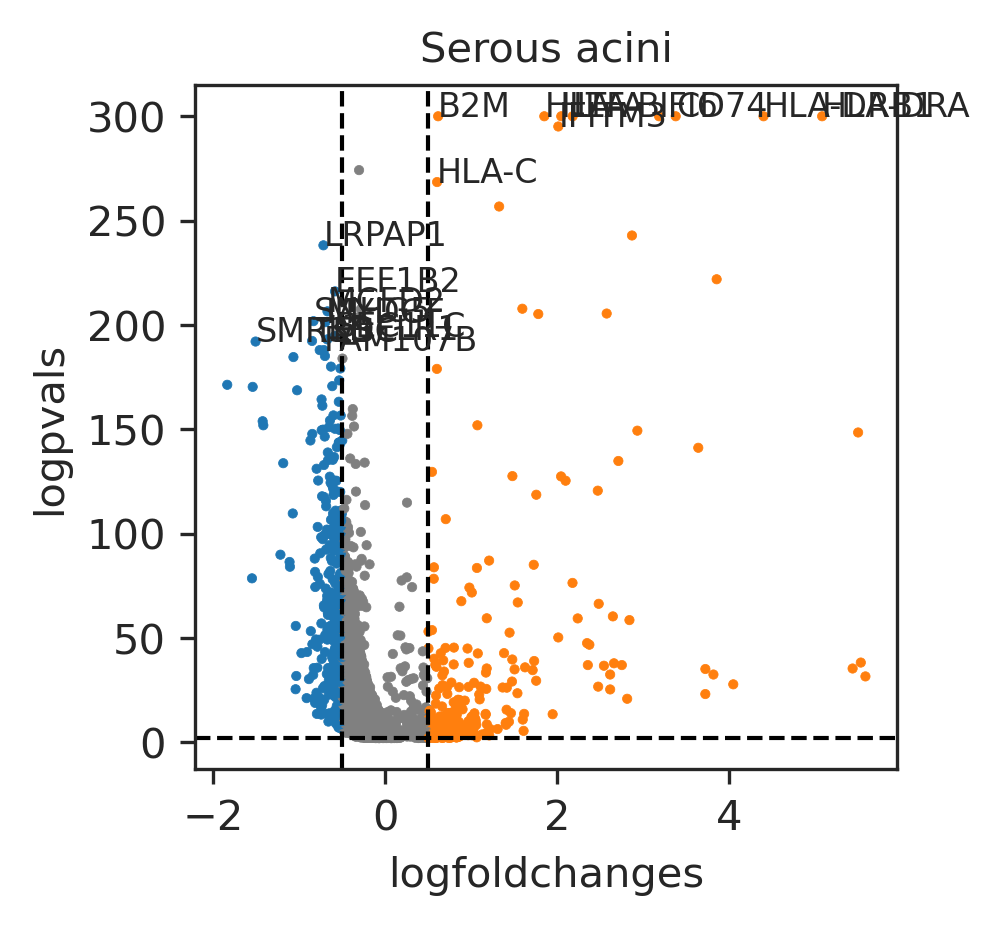

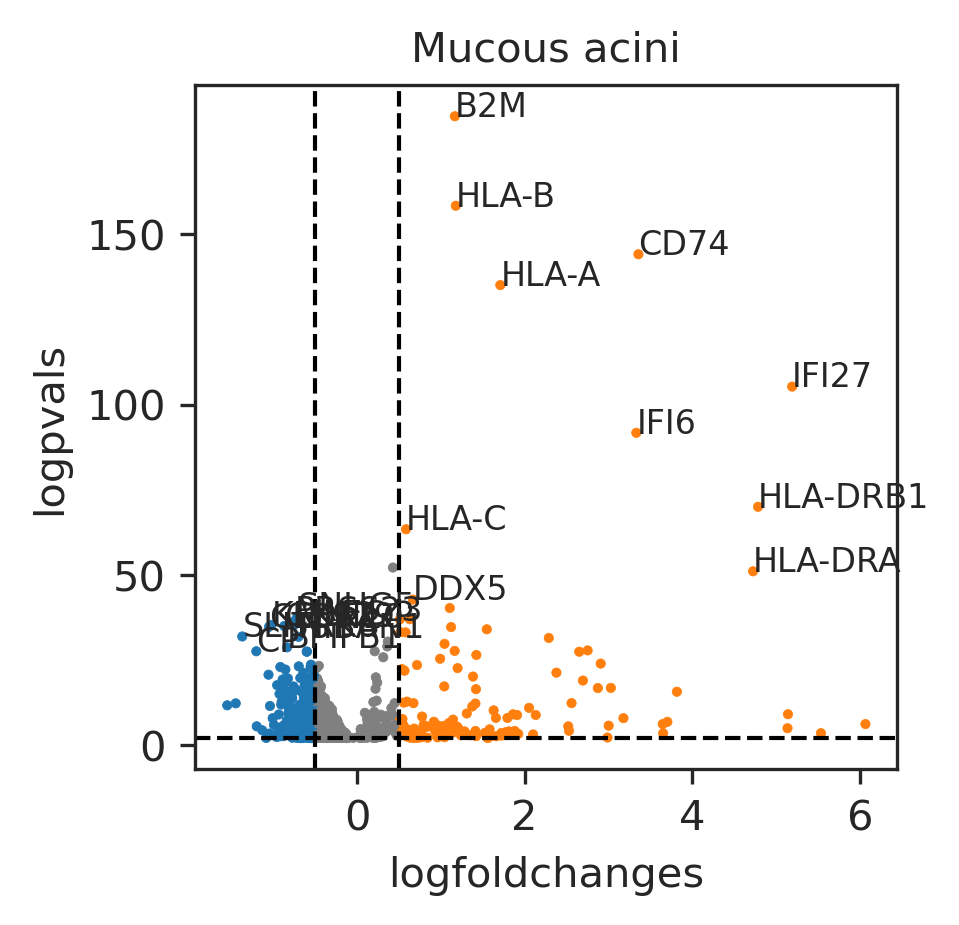

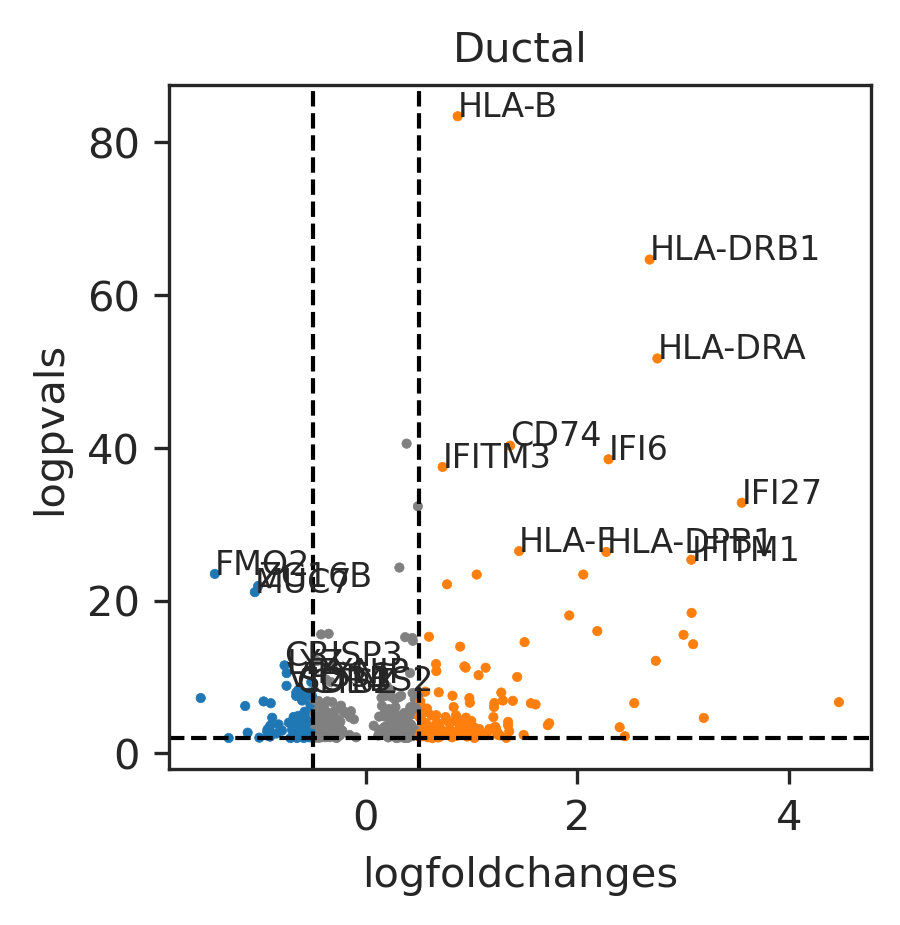

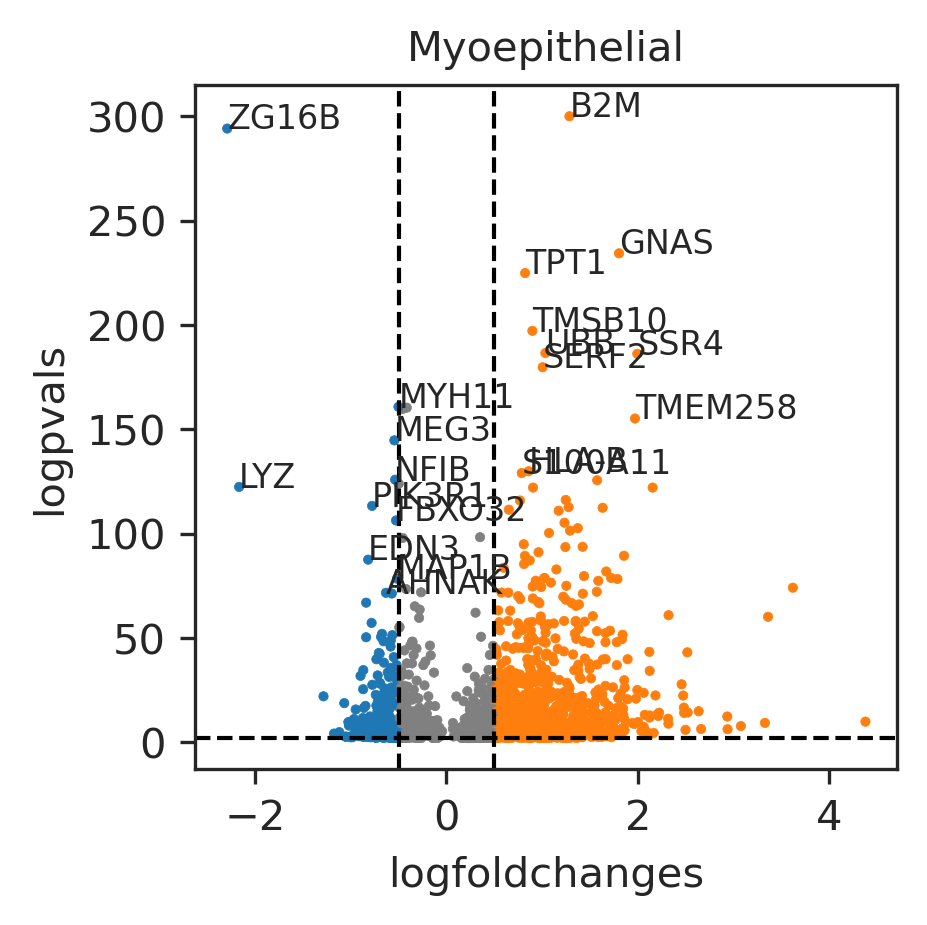

In [127]:
sns.set_style('ticks')
sns.scatterplot(x=serous_cli_state_degs['logfoldchanges'],y=serous_cli_state_degs['logpvals'],c=serous_cli_state_degs['color'],edgecolor=None,s=5)
plt.axvline(x=0.5,linewidth=1,linestyle='--',color='black')
plt.axvline(x=-0.5,linewidth=1,linestyle='--',color='black')
plt.axhline(y=2,linewidth=1,linestyle='--',color='black')
plt.title('Serous acini')
for ind in serous_cli_state_degs.loc[(np.abs(serous_cli_state_degs['logfoldchanges']) >= 0.5)&((serous_cli_state_degs['pvals_adj'] < 0.01)),:].head(10).index:
    plt.text(x=serous_cli_state_degs.loc[ind,'logfoldchanges'],y=serous_cli_state_degs.loc[ind,'logpvals'],s=serous_cli_state_degs.loc[ind,'names'],fontsize=8)
for ind in serous_cli_state_degs.loc[(np.abs(serous_cli_state_degs['logfoldchanges']) >= 0.5)&((serous_cli_state_degs['pvals_adj'] < 0.01)),:].tail(10).index:
    plt.text(x=serous_cli_state_degs.loc[ind,'logfoldchanges'],y=serous_cli_state_degs.loc[ind,'logpvals'],s=serous_cli_state_degs.loc[ind,'names'],fontsize=8)
plt.savefig('figures/vocanoplot_scatterplot_cx_serous_vocanoplot.pdf',bbox_inches='tight')
plt.show()

sns.set_style('ticks')
sns.scatterplot(x=mucous_cli_state_degs['logfoldchanges'],y=mucous_cli_state_degs['logpvals'],c=mucous_cli_state_degs['color'],edgecolor=None,s=5)
plt.axvline(x=0.5,linewidth=1,linestyle='--',color='black')
plt.axvline(x=-0.5,linewidth=1,linestyle='--',color='black')
plt.axhline(y=2,linewidth=1,linestyle='--',color='black')
plt.title('Mucous acini')
for ind in mucous_cli_state_degs.loc[(np.abs(mucous_cli_state_degs['logfoldchanges']) >= 0.5)&((mucous_cli_state_degs['pvals_adj'] < 0.01)),:].head(10).index:
    plt.text(x=mucous_cli_state_degs.loc[ind,'logfoldchanges'],y=mucous_cli_state_degs.loc[ind,'logpvals'],s=mucous_cli_state_degs.loc[ind,'names'],fontsize=8)
for ind in mucous_cli_state_degs.loc[(np.abs(mucous_cli_state_degs['logfoldchanges']) >= 0.5)&((mucous_cli_state_degs['pvals_adj'] < 0.01)),:].tail(10).index:
    plt.text(x=mucous_cli_state_degs.loc[ind,'logfoldchanges'],y=mucous_cli_state_degs.loc[ind,'logpvals'],s=mucous_cli_state_degs.loc[ind,'names'],fontsize=8)
plt.savefig('figures/vocanoplot_scatterplot_cx_mucous_vocanoplot.pdf',bbox_inches='tight')
plt.show()

sns.set_style('ticks')
sns.scatterplot(x=duct_cli_state_degs['logfoldchanges'],y=duct_cli_state_degs['logpvals'],c=duct_cli_state_degs['color'],edgecolor=None,s=5)
plt.axvline(x=0.5,linewidth=1,linestyle='--',color='black')
plt.axvline(x=-0.5,linewidth=1,linestyle='--',color='black')
plt.axhline(y=2,linewidth=1,linestyle='--',color='black')
plt.title('Ductal')
for ind in duct_cli_state_degs.loc[(np.abs(duct_cli_state_degs['logfoldchanges']) >= 0.5)&((duct_cli_state_degs['pvals_adj'] < 0.01)),:].head(10).index:
    plt.text(x=duct_cli_state_degs.loc[ind,'logfoldchanges'],y=duct_cli_state_degs.loc[ind,'logpvals'],s=duct_cli_state_degs.loc[ind,'names'],fontsize=8)
for ind in duct_cli_state_degs.loc[(np.abs(duct_cli_state_degs['logfoldchanges']) >= 0.5)&((duct_cli_state_degs['pvals_adj'] < 0.01)),:].tail(10).index:
    plt.text(x=duct_cli_state_degs.loc[ind,'logfoldchanges'],y=duct_cli_state_degs.loc[ind,'logpvals'],s=duct_cli_state_degs.loc[ind,'names'],fontsize=8)
plt.savefig('figures/vocanoplot_scatterplot_cx_ductal_vocanoplot.pdf',bbox_inches='tight')
plt.show()

sns.set_style('ticks')
sns.scatterplot(x=myoepi_cli_state_degs['logfoldchanges'],y=myoepi_cli_state_degs['logpvals'],c=myoepi_cli_state_degs['color'],edgecolor=None,s=5)
plt.axvline(x=0.5,linewidth=1,linestyle='--',color='black')
plt.axvline(x=-0.5,linewidth=1,linestyle='--',color='black')
plt.axhline(y=2,linewidth=1,linestyle='--',color='black')
plt.title('Myoepithelial')
for ind in myoepi_cli_state_degs.loc[(np.abs(myoepi_cli_state_degs['logfoldchanges']) >= 0.5)&((myoepi_cli_state_degs['pvals_adj'] < 0.01)),:].head(10).index:
    plt.text(x=myoepi_cli_state_degs.loc[ind,'logfoldchanges'],y=myoepi_cli_state_degs.loc[ind,'logpvals'],s=myoepi_cli_state_degs.loc[ind,'names'],fontsize=8)
for ind in myoepi_cli_state_degs.loc[(np.abs(myoepi_cli_state_degs['logfoldchanges']) >= 0.5)&((myoepi_cli_state_degs['pvals_adj'] < 0.01)),:].tail(10).index:
    plt.text(x=myoepi_cli_state_degs.loc[ind,'logfoldchanges'],y=myoepi_cli_state_degs.loc[ind,'logpvals'],s=myoepi_cli_state_degs.loc[ind,'names'],fontsize=8)
plt.savefig('figures/vocanoplot_scatterplot_cx_epi_myo_vocanoplot.pdf',bbox_inches='tight')
plt.show()